In [107]:
import numpy as np
import matplotlib.pyplot as plt
from functions import polyeig 
import matplotlib_settting
from scipy.integrate import simpson

# Linear elements
Let $ \tilde{v}(z) = \sum_{j=1}^{N} c_ju_j(z) $ where $u_j(z)$ are tent functions that peaks at $x_j\in(-1,1)$.

In [95]:
N = 100 # number of tent functions

dx = 2/(N+1)
node = np.linspace(-1+dx,1-dx,N)

u = lambda x,n: np.piecewise(x, [np.abs(x-node[n])/dx<=1], [lambda x: -np.abs(x-node[n])/dx+1, 0])
u_p = lambda x,n: np.piecewise(
    x,
    [((x-node[n])/dx>=-1) & ((x-node[n])/dx<0), ((x-node[n])/dx>=0) & ((x-node[n])/dx<1)],
    [1/dx,-1/dx,0]
)
u_pp = lambda x,n: 0

x = np.linspace(-1,1,1000)

# for n in range(N):
#     lines = plt.plot(x, u(x,n))
#     plt.plot(x,u_p(x,n),'--',color=lines[0]._color)

In [96]:
v0 = 0.5
A2 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(N):
    for j in range(N):
        if np.abs(i-j)<=1:
            A2[i,j] = simpson(u(x,i)*u(x,j),x)
            A1[i,j] = 2j*v0*simpson(u(x,i)*u_p(x,j),x)
            A0[i,j] = (1-v0**2)*simpson(u(x,i)*u_pp(x,j),x)

[ 1.09189963+1.82248604e-13j  3.58998723+1.86641335e-13j
  5.73572953+1.51321382e-13j  8.28258159+1.80475999e-13j
 10.12398589+1.70506773e-13j 12.96943101+1.50191387e-13j
 15.92263312+1.77108593e-13j 17.63201031+2.00893527e-13j
 20.17333964+1.63065034e-13j 22.29315254+1.53457545e-13j]
[ 1.17809725  2.35619449  3.53429174  4.71238898  5.89048623  7.06858347
  8.24668072  9.42477796 10.60287521]


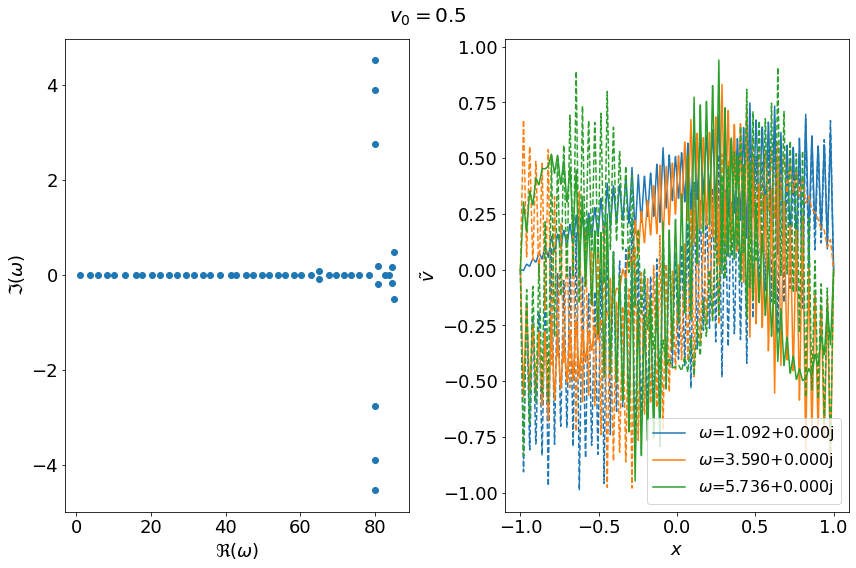

In [97]:
# finite-element + linear eigenvalue problem
C,omega = polyeig(A0,A1,A2)

selection = (np.real(omega)>1e-1) #& (np.abs(np.imag(omega)) > 1)
C = C[:,selection]
omega = omega[selection]

# sort
ind = np.argsort(np.real(omega))
omega = omega[ind]
C = C[:,ind]

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.subplot(122)
for i in range(3):
    v = 0
    for n in range(N):
        v += C[n,i]*u(x,n)
    line = plt.plot(x, np.real(v), label=f"$\omega$={omega[i]:.3f}")
    plt.plot(x, np.imag(v), '--', color=line[0]._color)

plt.xlabel("$x$")
plt.ylabel("$\\tilde{v}$")
plt.legend()
plt.suptitle(f"$v_0={v0}$")
plt.tight_layout()

print(omega[:10])
print(np.abs(1-v0**2)*np.pi/2*np.arange(1,10))

# Cubic B Spline
Let $ \tilde{v} = \sum_{n=0}^{N} c_nP_n(x) $, where $P_n(x)$ are cubic B spline.

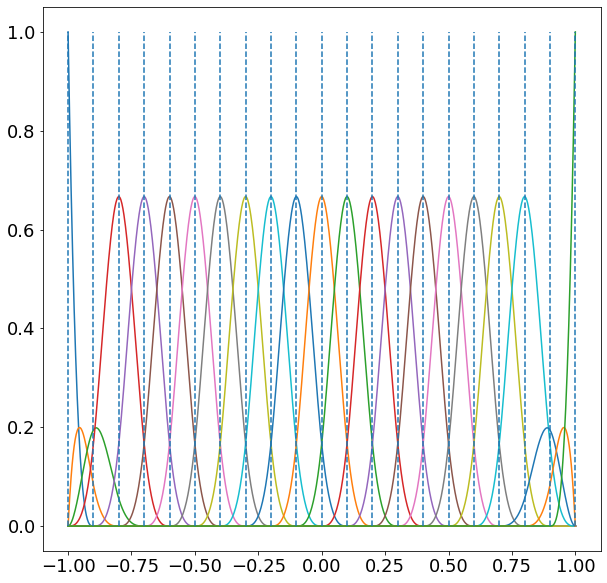

In [10]:
def phi(x:float,j:int,node):
    """ B-spline """
    h = 1/N # originally, B-spline is defined on [0,1] 
    if j == -1:
        y = x/h
        f1 = lambda y: 1 - 3*y + 3*y**2 - y**3
        f2 = lambda y: 0
        return np.piecewise(
            y,
            [(0<=y)&(y<1)],
            [f1,f2]
        )
        # return np.zeros_like(x) # Dirichlet boundary condition
    elif j == 0:
        y = x/h
        f1 = lambda y: y - 3/2*y**2 + 7/12*y**3
        f2 = lambda y: 2/3 - y + 1/2*y**2 - 1/12*y**3
        f3 = lambda y: 0
        return np.piecewise(
            y,
            [(0<=y)&(y<1), (1<=y)&(y<2)],
            [f1,f2,f3]
        )
    elif j == 1:
        y = x/h
        f1 = lambda y: y**2/2 - 11/36*y**3
        f2 = lambda y: -1/2 + 3/2*y - y**2 + 7/36*y**3
        f3 = lambda y: 3/2 - 3/2*y + 1/2*y**2 - 1/18*y**3
        f4 = lambda y: 0
        return np.piecewise(
            y,
            [(0<=y)&(y<1), (1<=y)&(y<2), (2<=y)&(y<3)],
            [f1,f2,f3,f4]
        )
    elif j == N-1:
        y = (x-node[-1])/h
        f1 = lambda y: y**2/2 + 11/36*y**3
        f2 = lambda y: -1/2 - 3/2*y - y**2 - 7/36*y**3
        f3 = lambda y: 3/2 + 3/2*y + 1/2*y**2 + 1/18*y**3
        f4 = lambda y: 0
        return np.piecewise(
            y,
            [(-1<y)&(y<=0), (-2<y)&(y<=-1), (-3<y)&(y<=-2)],
            [f1,f2,f3,f4]
        )
    elif j == N:
        y = (x-node[-1])/h
        f1 = lambda y: -y - 3/2*y**2 - 7/12*y**3
        f2 = lambda y: 2/3 + y + 1/2*y**2 + 1/12*y**3
        f3 = lambda y: 0
        return np.piecewise(
            y,
            [(-1<y)&(y<=0), (-2<y)&(y<=-1)],
            [f1,f2,f3]
        )
    elif j == N+1:
        y = (x-node[-1])/h
        f1 = lambda y: 1 + 3*y + 3*y**2 + y**3
        f2 = lambda y: 0
        return np.piecewise(
            y,
            [(-1<y)&(y<=0)],
            [f1,f2]
        )
        # return np.zeros_like(x) # Dirichlet boundary condition
    else:
        y = x/h - j
        f1 = lambda y: 4/3 + 2*y + y**2 + y**3/6
        f2 = lambda y: 2/3 - y**2 - y**3/2
        f3 = lambda y: 2/3 - y**2 + y**3/2
        f4 = lambda y: 4/3 - 2*y + y**2 - y**3/6
        f5 = lambda y: 0
        return np.piecewise(
            y, 
            [(-2<=y)&(y<-1), (-1<=y)&(y<0), (0<=y)&(y<1), (1<=y)&(y<2)], 
            [f1,f2,f3,f4,f5]
        )

def u(x,j):
    node = 2*np.linspace(0,1,N+1) - 1
    return phi((x+1)/2, j, node)

N = 20

plt.figure()
x = np.linspace(-1,1,1000) # shift the domain to [-1,1]
for n in range(-1,N+2):
    plt.plot(x, u(x,n))
plt.vlines(2*np.linspace(0,1,N+1)-1, 0,1, linestyle='--') # plot nodes

In [11]:
x = np.linspace(-1,1,1000)
dx = x[1]-x[0]
D = (np.diag(np.ones_like(x))-np.diag(np.ones_like(x)))/(2*dx)
D[0,:3] = np.array([-3,4,-1])/(2*dx)
D[-1,-3:] = np.array([-1,4,-3])/(2*(-dx))

v0 = 0.5
A2 = np.zeros((N+3,N+3), dtype=complex) # n from -1 to N+1
A1 = np.zeros((N+3,N+3), dtype=complex)
A0 = np.zeros((N+3,N+3), dtype=complex)
for i in range(N+3):
    for j in range(N+3):
        if np.abs(i-j) <= 3:
            A2[i,j] = simpson(u(x,i-1)*u(x,j-1),x)
            A1[i,j] = 2j*v0*simpson(u(x,i-1)*(D@u(x,j-1)),x)
            A0[i,j] = (1-v0**2)*simpson(u(x,i-1)*(D@D@u(x,j-1)),x)

A0[0,:] = 0
A0[0,0] = 1
A0[-1,:] = 0
A0[-1,-1] = 1
A1[0,:] = 0
A1[0,0] = 1
A1[-1,:] = 0
A1[-1,-1] = 1
A2[0,:] = 0
A2[0,0] = 1
A2[-1,:] = 0
A2[-1,-1] = 1

[2.20234888e-75+1.27863285e-75j 4.11205806e-73+1.65295008e-72j
 2.05855764e-68-2.77448709e-68j 1.11232719e-61-3.56650590e-62j
 6.23565480e-56-9.23974002e-56j 1.58893656e-55-1.16958736e-54j
 5.47645835e-52-1.28947336e-52j 5.01641506e-49+1.60153403e-48j
 1.20630029e-39-4.09195023e-39j 4.38818230e-37-1.17780297e-38j]
[ 0.          1.17809725  2.35619449  3.53429174  4.71238898  5.89048623
  7.06858347  8.24668072  9.42477796 10.60287521]


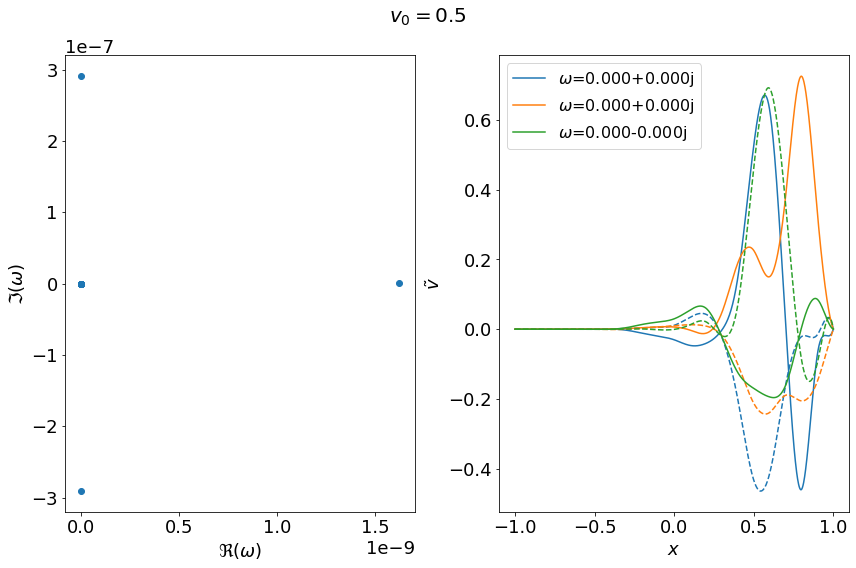

In [12]:
# finite-element + linear eigenvalue problem
C,omega = polyeig(A0,A1,A2)

selection = (np.real(omega)>0) #& (np.abs(np.imag(omega)) > 1)
C = C[:,selection]
omega = omega[selection]

# sort
ind = np.argsort(np.real(omega))
omega = omega[ind]
C = C[:,ind]

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.subplot(122)
for i in range(3):
    v = 0
    for n in range(N+1):
        v += C[n,i]*u(x,n)
    line = plt.plot(x, np.real(v), label=f"$\omega$={omega[i]:.3f}")
    plt.plot(x, np.imag(v), '--', color=line[0]._color)

plt.xlabel("$x$")
plt.ylabel("$\\tilde{v}$")
plt.legend()
plt.suptitle(f"$v_0={v0}$")
plt.tight_layout()

print(omega[:10])
print(np.abs(1-v0**2)*np.pi/2*np.arange(10))

Text(0.5, 1.0, '$v_0$=1.0')

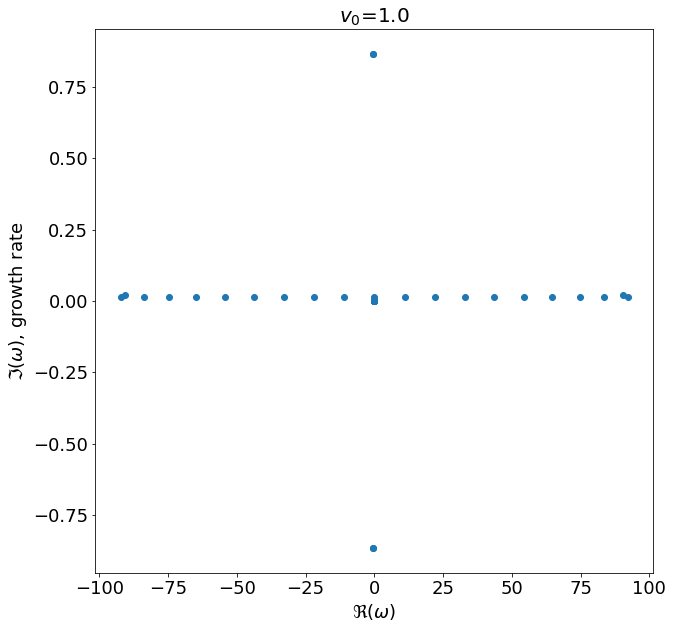

In [124]:
# phase space
plt.figure()
selection = (np.abs(np.real(omega))<0.3) & (np.abs(np.imag(omega))<1000)
omega_ = omega#[selection]

plt.plot(np.real(omega_), np.imag(omega_), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$, growth rate")
plt.title(f"$v_0$={v0}")

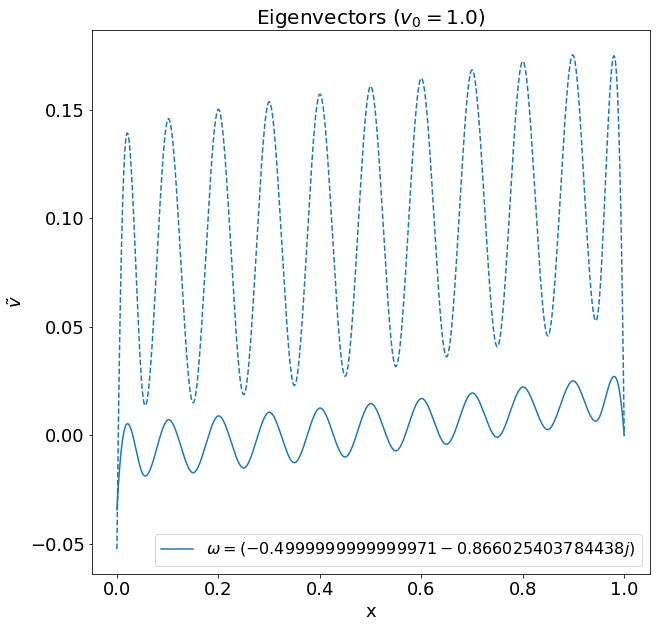

In [128]:
# eigenvectors
plt.figure()
selection = (np.abs(np.imag(omega))>0.5) & (np.abs(np.real(omega))>0)
omega_ = omega[selection]
C_ = C[:, selection]

ind = np.argsort(np.abs(np.imag(omega_)))
omega_ = omega_[ind]
C_ = C_[:,ind]

x = np.linspace(0,1,1000)
for i in range(1):
    v = 0
    for n in range(N+3):
        v += C_[n,i]*phi(x,n-1)
    lines = plt.plot(x, np.real(v), label=f"$\omega={omega_[i]}$")
    plt.plot(x, np.imag(v), '--', color=lines[0]._color)
plt.xlabel("x")
plt.ylabel("$\\tilde{v}$")
plt.title(f"Eigenvectors ($v_0={v0}$)")
plt.legend();

# SINE
$$ \omega^2\tilde{v} + 2i\omega v_0\tilde{v}' + (1-v_0^2)\tilde{v}'' = 0 $$

Let $ \tilde{v} = \sum_{n=1}^{N} a_n\sin(\frac{n\pi}{2}(x+1)) $. Using this, the equation becomes

$$ \left(\delta_{jk}\omega^2 + 2iv_0 mod(j-k,2)\left( 2\frac{jk}{j^2-k^2} \right)\omega - (1-v_0^2)\left(\frac{j\pi}{2}\right)^2\delta_{jk} \right)\mathbf{a} = \mathbf{0} $$

In [109]:
N = 50
L = 2
x0 = -1
u = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))


v0 = 5
A2 = np.eye(N,dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(1,N+1):
    for j in range(1,N+1):
        if i==j:
            A0[i-1,j-1] = -(1-v0**2)*(i*np.pi/2)**2
        if (i-j)%2 != 0:
            A1[i-1,j-1] = 2j*v0 * (4/L*i*j/(i**2-j**2))


# O = np.zeros((N,N), dtype=complex)
# I = np.eye(N,dtype=complex)
# A21 = np.zeros((N,N), dtype=complex)
# A22 = np.zeros((N,N), dtype=complex)

# for i in range(1,N+1):
#     for j in range(1,N+1):
#         if i==j:
#             A21[i-1,j-1] = (1-v0**2)*(i*np.pi/2)**2
            
#         if (i-j)%2 != 0:
#             A22[i-1,j-1] = -2j*v0 * (4/L*i*j/(np.pi*(i**2-j**2)))

[ 7.28070852+3.40483006e+01j  7.28070852-3.40483006e+01j
 22.14891333+3.29062916e+01j 22.14891333-3.29062916e+01j
 37.70323066+1.58118488e-14j 37.8166676 +3.10109590e+01j
 37.8166676 -3.10109590e+01j 54.30144742+2.89721152e+01j
 54.30144742-2.89721152e+01j 71.32947869+2.69509855e+01j]
[ 37.69911184  75.39822369 113.09733553 150.79644737 188.49555922
 226.19467106 263.8937829  301.59289474 339.29200659]


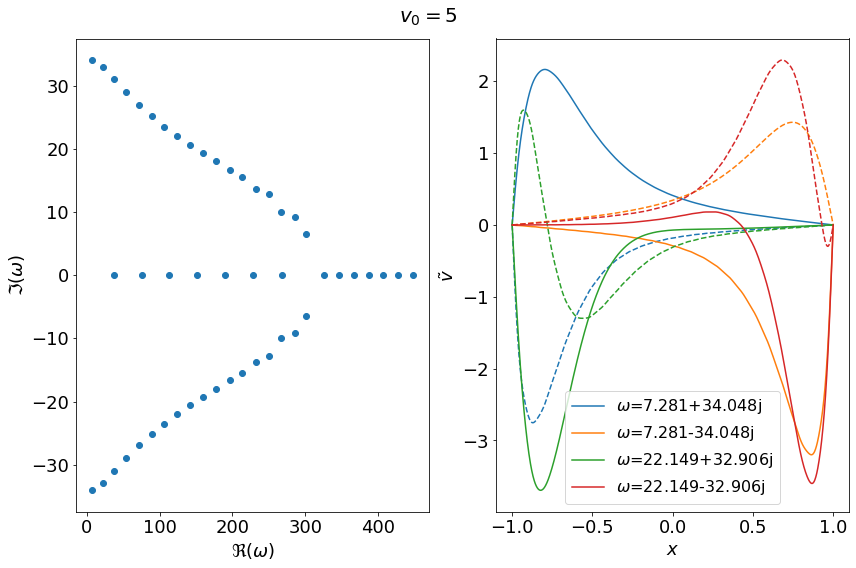

In [110]:
# finite-element + linear eigenvalue problem
C,omega = polyeig(A0,A1,A2)

selection = (np.real(omega)>0) #& (np.abs(np.imag(omega)) > 1)
C = C[:,selection]
omega = omega[selection]

# sort
ind = np.argsort(np.real(omega))
omega = omega[ind]
C = C[:,ind]

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.subplot(122)
for i in range(4):
    v = 0
    for n in range(N):
        v += C[n,i]*u(x,n)
    line = plt.plot(x, np.real(v), label=f"$\omega$={omega[i]:.3f}")
    plt.plot(x, np.imag(v), '--', color=line[0]._color)

plt.xlabel("$x$")
plt.ylabel("$\\tilde{v}$")
plt.legend()
plt.suptitle(f"$v_0={v0}$")
plt.tight_layout()

print(omega[:10])
print(np.abs(1-v0**2)*np.pi/2*np.arange(1,10))

# Legendre Polynomial
$$ \omega^2\tilde{v} + 2i\omega v_0\tilde{v}' + (1-v_0^2)\tilde{v}'' = 0 $$

Let $ \tilde{v} = \sum_{n=0}^{N} c_nP_n(x) $, where $P_n(x)$ are Legendre polynomials.

In [ ]:
import numpy.polynomial.legendre as leg

def integrate_PP(i,j):
    ci = np.zeros(N)
    cj = np.zeros(N)
    ci[i] = 1
    cj[j] = 1
    c = leg.legmul(ci,cj)
    return np.diff(leg.legval([-1,1], leg.legint(c)))[0]

def integrate_PdP(i,j):
    ci = np.zeros(N)
    cj = np.zeros(N)
    ci[i] = 1
    cj[j] = 1
    c = leg.legmul(ci, leg.legder(cj))
    return np.diff(leg.legval([-1,1], leg.legint(c)))[0]

def integrate_PddP(i,j):
    ci = np.zeros(N)
    cj = np.zeros(N)
    ci[i] = 1
    cj[j] = 1
    c = leg.legmul(ci, leg.legder(leg.legder(cj)))
    return np.diff(leg.legval([-1,1], leg.legint(c)))[0]

In [ ]:
v0 = 1.5

N = 20
A0 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A2 = np.zeros((N,N),dtype=complex)

for i in range(N):
    for j in range(N):
        A2[i,j] = integrate_PP(i,j)
        A1[i,j] = 2j*v0*integrate_PdP(i,j)
        A0[i,j] = (1-v0**2)*integrate_PddP(i,j)

C,omega = polyeig(A0,A1,A2)

Text(0.5, 1.0, '$v_0$=1.5')

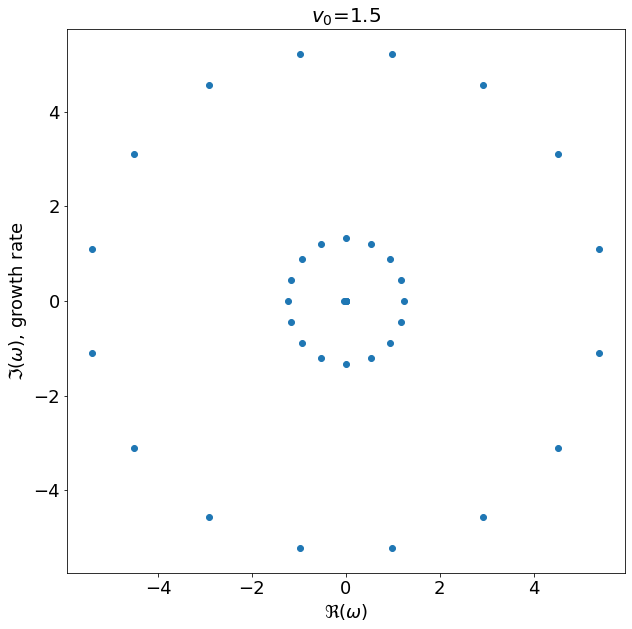

In [ ]:
# phase space
plt.figure()
selection = (np.abs(np.real(omega))<100) & (np.abs(np.imag(omega))<1000)
omega_ = omega#[selection]

plt.plot(np.real(omega_), np.imag(omega_), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$, growth rate")
plt.title(f"$v_0$={v0}")

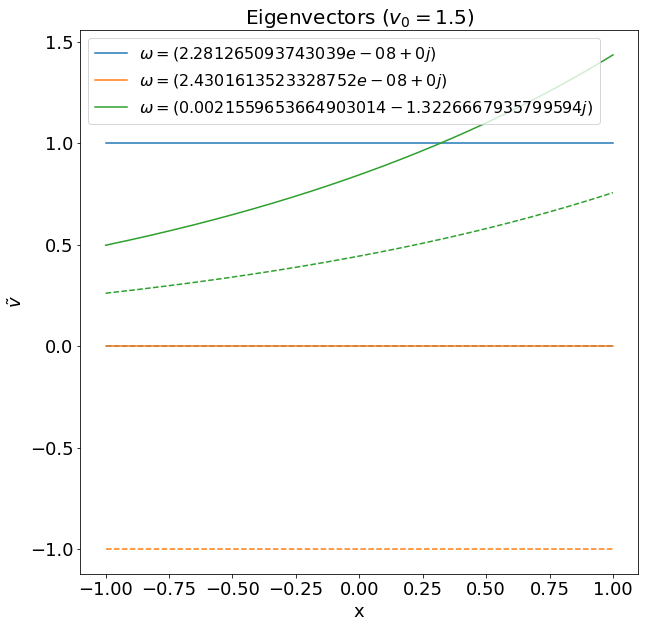

In [ ]:
# eigenvectors
plt.figure()
selection = (np.real(omega)>0)
omega_ = omega[selection]
C_ = C[:, selection]

ind = np.argsort(np.abs(np.real(omega_)))
omega_ = omega_[ind]
C_ = C_[:,ind]

x = np.linspace(-1,1,1000)
for i in range(3):
    v = leg.legval(x,C_[:,i])
    v_real = np.real(v)
    v_imag = np.imag(v)
    lines = plt.plot(x, v_real, label=f"$\omega={omega_[i]}$")
    plt.plot(x, v_imag, '--', color=lines[0]._color)
plt.xlabel("x")
plt.ylabel("$\\tilde{v}$")
plt.title(f"Eigenvectors ($v_0={v0}$)")
plt.legend();